In [15]:
import os
import numpy as np
import tensorflow as tf
import pickle
import imageio
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

## Загрузка словаря классов и индексов выборок

In [13]:
classes = {} #name, amount of material, [indexes of train images], [indexes of test images], [test_data], [test_labels]
pickle_classes_file = 'clapeyron_CNN_v0.2_classes.pickle'

tst_size_per_one_class = 100
trn_size_per_one_class = 0

try:
    with open(pickle_classes_file, 'rb') as f:
        classes = pickle.load(f)
    min_class_number = 10000000
    for i in range(len(classes)):
        len_current_class = classes[i][1]
        if (len_current_class < min_class_number):
            min_class_number = len_current_class
    print('min_class_number',min_class_number)
    trn_size_per_one_class = min_class_number - tst_size_per_one_class
    print('trn_size_per_one_class',trn_size_per_one_class)
    print('tst_size_per_one_class',tst_size_per_one_class)
    print('Сlasses dict loaded successfully')
except:
    print('No saved classes dict, computing classes...')
    min_class_number = 10000000
    list_classes = os.listdir('./data/data_training')
    for i in range(len(list_classes)):
        len_current_class = len(os.listdir('./data/data_training'+'/'+list_classes[i]))
        classes[i] = [list_classes[i],len_current_class,[],[],[],[]]
        if (len_current_class < min_class_number):
            min_class_number = len_current_class
    print('min_class_number',min_class_number)
    trn_size_per_one_class = min_class_number - tst_size_per_one_class
    print('trn_size_per_one_class',trn_size_per_one_class)
    print('tst_size_per_one_class',tst_size_per_one_class)
    for i in range(len(list_classes)):
        shuffled_class_indexes = np.random.permutation(len_current_class)
        shuffled_class_indexes = np.random.permutation(shuffled_class_indexes) #double shuffling
        classes[i][2] = shuffled_class_indexes[:trn_size_per_one_class]
        classes[i][3] = shuffled_class_indexes[trn_size_per_one_class:trn_size_per_one_class+100]
        pixel_depth = 255.
        for j in range(tst_size_per_one_class):
            img = imageio.imread('./data/data_training/'+classes[i][0]
                             +'/imagenet'+classes[i][0]+str(classes[i][3][j])
                             +'.jpg').astype(np.float32)
            image_data = (img - pixel_depth / 2) / pixel_depth
            classes[i][4].append(image_data)
            label = np.zeros(len(classes))
            label[i] = 1
            classes[i][5].append(label)
        classes[i][4] = np.array(classes[i][4])
        classes[i][5] = np.array(classes[i][5]) 
    with open(pickle_classes_file, 'wb') as f:
        pickle.dump(classes,f)
    print('Сlasses dict saved and computed successfully')

N = len(classes) #number of classes
pixel_depth = 255.
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) 
            / predictions.shape[0])

min_class_number 749
trn_size_per_one_class 649
tst_size_per_one_class 100
Сlasses dict loaded successfully


## Конфигурация сети

In [4]:
batch_size = 100 #must be %10 == 0

In [5]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.05)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.zeros(shape)
  return tf.Variable(initial)

In [6]:
graph = tf.Graph()

with graph.as_default():
    
    conv_kernel_size = 3
    conv_kernel_stride = 1
    pool_kernel_size = 2
    pool_kernel_stride = 2
    
    input_size = 224
    pool1_size = 112
    pool2_size = 56
    pool3_size = 28
    pool4_size = 14
    pool5_size = 7
    
    input_depth = 3
    block1_depth = 16
    block2_depth = 32
    block3_depth = 64
    block4_depth = 128
    block5_depth = 128
    FC1_depth = 512
    dropout1_prob = 0.8
    FC2_depth = 256
    dropout2_prob = 0.8
    FC_output_depth = 10
    
    conv1_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,input_depth,block1_depth])
    conv1_1_biases = bias_variable([block1_depth])
    conv1_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block1_depth,block1_depth])
    conv1_2_biases = bias_variable([block1_depth])
    
    conv2_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,block1_depth,block2_depth])
    conv2_1_biases = bias_variable([block2_depth])
    conv2_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block2_depth,block2_depth])
    conv2_2_biases = bias_variable([block2_depth])
    
    conv3_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,block2_depth,block3_depth])
    conv3_1_biases = bias_variable([block3_depth])
    conv3_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block3_depth,block3_depth])
    conv3_2_biases = bias_variable([block3_depth])
    
    conv4_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,block3_depth,block4_depth])
    conv4_1_biases = bias_variable([block4_depth])
    conv4_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block4_depth,block4_depth])
    conv4_2_biases = bias_variable([block4_depth])
    
    conv5_1_weights = weight_variable([conv_kernel_size,conv_kernel_size,block4_depth,block5_depth])
    conv5_1_biases = bias_variable([block5_depth])
    conv5_2_weights = weight_variable([conv_kernel_size,conv_kernel_size,block5_depth,block5_depth])
    conv5_2_biases = bias_variable([block5_depth])
    
    FC1_weights = weight_variable([pool5_size,pool5_size,block5_depth,FC1_depth])
    FC1_biases = bias_variable([FC1_depth])
    FC2_weights = weight_variable([1,1,FC1_depth,FC2_depth])
    FC2_biases = bias_variable([FC2_depth])
    FC_output_weights = weight_variable([1,1,FC2_depth,FC_output_depth])
    FC_output_biases = bias_variable([FC_output_depth])
    
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_size, input_size, input_depth))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, FC_output_depth))
    tf_test_dataset = tf.placeholder(tf.float32, shape=(tst_size_per_one_class, input_size, input_size, input_depth))

    saver = tf.train.Saver(max_to_keep=0)
    
    def conv_model(data):
        conv1_1 = tf.nn.conv2d(data,conv1_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu1_1 = tf.nn.relu(conv1_1 + conv1_1_biases)

        conv1_2 = tf.nn.conv2d(relu1_1,conv1_2_weights,strides=[1,1,1,1],padding='SAME')
        relu1_2 = tf.nn.relu(conv1_2 + conv1_2_biases)

        pool1   = tf.nn.max_pool(relu1_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        conv2_1 = tf.nn.conv2d(pool1,conv2_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu2_1 = tf.nn.relu(conv2_1 + conv2_1_biases)

        conv2_2 = tf.nn.conv2d(relu2_1,conv2_2_weights,strides=[1,1,1,1], padding='SAME')
        relu2_2 = tf.nn.relu(conv2_2 + conv2_2_biases)

        pool2   = tf.nn.max_pool(relu2_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        conv3_1 = tf.nn.conv2d(pool2,conv3_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu3_1 = tf.nn.relu(conv3_1 + conv3_1_biases)

        conv3_2 = tf.nn.conv2d(relu3_1,conv3_2_weights,strides=[1,1,1,1],padding='SAME')
        relu3_2 = tf.nn.relu(conv3_2 + conv3_2_biases)

        pool3   = tf.nn.max_pool(relu3_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        conv4_1 = tf.nn.conv2d(pool3,conv4_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu4_1 = tf.nn.relu(conv4_1 + conv4_1_biases)

        conv4_2 = tf.nn.conv2d(relu4_1,conv4_2_weights,strides=[1,1,1,1],padding='SAME')
        relu4_2 = tf.nn.relu(conv4_2 + conv4_2_biases)

        pool4   = tf.nn.max_pool(relu4_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')

        conv5_1 = tf.nn.conv2d(pool4,conv5_1_weights,strides=[1, 1, 1, 1],padding='SAME')
        relu5_1 = tf.nn.relu(conv5_1 + conv5_1_biases)

        conv5_2 = tf.nn.conv2d(relu5_1,conv5_2_weights,strides=[1,1,1,1],padding='SAME')
        relu5_2 = tf.nn.relu(conv5_2 + conv5_2_biases)

        pool5   = tf.nn.max_pool(relu5_2,ksize=[1,2,2,1],strides=[1,2,2,1],padding='VALID')
        return pool5
    
    def FC_model_train(pool5):
        FC1     = tf.nn.conv2d(pool5,FC1_weights,strides=[1,1,1,1],padding='VALID')
        reluFC1 = tf.nn.relu(FC1 + FC1_biases)
        dropout1 = tf.nn.dropout(reluFC1,dropout1_prob)

        FC2     = tf.nn.conv2d(dropout1,FC2_weights,strides=[1,1,1,1],padding='VALID')
        reluFC2 = tf.nn.relu(FC2 + FC2_biases)
        dropout2 = tf.nn.dropout(reluFC2,dropout2_prob)

        FC_output = tf.nn.conv2d(dropout2,FC_output_weights,strides=[1,1,1,1],padding='VALID') + FC_output_biases
        return tf.reshape(FC_output,[int(pool5.shape[0]),10])
    
    def FC_model_predict(pool5):
        FC1     = tf.nn.conv2d(pool5,FC1_weights,strides=[1,1,1,1],padding='VALID')
        reluFC1 = tf.nn.relu(FC1 + FC1_biases)

        FC2     = tf.nn.conv2d(reluFC1,FC2_weights,strides=[1,1,1,1],padding='VALID')
        reluFC2 = tf.nn.relu(FC2 + FC2_biases)

        FC_output = tf.nn.conv2d(reluFC2,FC_output_weights,strides=[1,1,1,1],padding='VALID') + FC_output_biases
        return tf.reshape(FC_output,[int(pool5.shape[0]),10])
    
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, input_size, input_size, input_depth))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, FC_output_depth))
    train_logits = FC_model_train(conv_model(tf_train_dataset))
    train_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels,logits=train_logits))
    optimizer = tf.train.GradientDescentOptimizer(0.07).minimize(train_loss)
    train_prediction = tf.nn.softmax(train_logits)
    
    tf_test_dataset = tf.placeholder(tf.float32, shape=(tst_size_per_one_class, input_size, input_size, input_depth))
    tf_test_labels = tf.placeholder(tf.float32, shape=(tst_size_per_one_class, FC_output_depth))
    test_logits = FC_model_predict(conv_model(tf_test_dataset))
    test_prediction  = tf.nn.softmax(test_logits)
    test_losses = tf.nn.softmax_cross_entropy_with_logits(labels=tf_test_labels,logits=test_logits)
    test_loss = tf.reduce_mean(test_losses)
    
    tf_one_image = tf.placeholder(tf.float32, shape=(1, input_size, input_size, input_depth))
    tf_one_label = tf.placeholder(tf.float32, shape=(1, FC_output_depth))
    one_prediction = tf.nn.softmax(FC_model_predict(conv_model(tf_one_image)))
    one_loss = tf.nn.softmax_cross_entropy_with_logits(labels=tf_one_label,logits=one_prediction)

## Функции аугментации

In [6]:
#30% - standart (256x256 resizing)
#rotation (0-1-2-3)
#horizontal reflection (flipping)
#not central crop from 256x256
#crop from axb (196<a,b<332)

In [7]:
def augm_rescaling(image,size): #PIL.Image.Image, size=a,b(196<a,b<332)
    im = image.resize(size)
    return im

In [8]:
def augm_centralcrop(image): #PIL.Image.Image, imagesizes:(196<a,b<332)
    left = (image.width-input_size)/2
    upper = (image.height-input_size)/2
    right = (image.width-left)
    bottom = (image.height-upper)
    im = image.crop((left,upper,right,bottom)) #left,upper,right,bottom pixels of rectangle
    return im #(224x224)

In [9]:
def augm_crop(image,shifts): #PIL.Image.Image, shiftsizes ()
    left = (image.width-input_size)*shifts[0] #0.5 - is center
    upper = (image.height-input_size)*shifts[1]
    right = (left+input_size)
    bottom = (upper+input_size)
    im = image.crop((left,upper,right,bottom)) #left,upper,right,bottom pixels of rectangle
    return im #(224x224)

In [10]:
def augm_horizontalreflection(image):
    im = image.transpose(Image.FLIP_TOP_BOTTOM)
    return im

In [11]:
def augm_rotation(image,i):
    if (i==0):
        im = image
    if (i==1):
        im = image.transpose(Image.ROTATE_90)
    if (i==2):
        im = image.transpose(Image.ROTATE_180)
    if (i==3):
        im = image.transpose(Image.ROTATE_270)
    return im

## Генерация батча

In [12]:
def gen_standart_or_not():
    arr = np.random.permutation(N)
    if (arr[0]<3):
        return True
    else:
        return False

In [13]:
size_range = np.arange(224,372,2) #196,198,...,332
def gen_rescaling():
    width = size_range[np.random.permutation(size_range.shape[0])][0]
    height = size_range[np.random.permutation(size_range.shape[0])][0]
    return (width,height)

In [14]:
def gen_binary():
    arr = np.random.permutation(2)
    if (arr[0]==0):
        return False
    else:
        return True

In [15]:
def gen_quadruple():
    arr = np.random.permutation(4)
    return arr[0]

In [16]:
shifts_range = np.arange(0.1,1.0,0.1)
def gen_cropshifts():
    shiftx = shifts_range[np.random.permutation(shifts_range.shape[0])][0]
    shifty = shifts_range[np.random.permutation(shifts_range.shape[0])][0]
    return (shiftx,shifty)

In [17]:
def return_augmented_data(image):
    if (gen_standart_or_not()):
        image = augm_centralcrop(augm_rescaling(image,(256,256)))
    else:
        image = augm_rescaling(image,(gen_rescaling()))
        if (gen_binary()):
            image = augm_horizontalreflection(image)
        image = augm_rotation(image,gen_quadruple())
        image = augm_crop(image,gen_cropshifts())
    image_data = np.array(image,dtype=np.float32)
    image_data = (image_data - pixel_depth / 2) / pixel_depth
    return image_data

In [18]:
N = len(classes) #number of classes
pixel_depth = 255.0
if(batch_size%N != 0):
    print('WARNING:',batch_size,'%',N,'!=',0)
def generate_batch():
    batch_data = []
    batch_labels = []
    for i in range(N):
        class_batch_size = int(batch_size/N)
        class_batch_indexes = np.random.permutation(trn_size_per_one_class)[:class_batch_size]
        for j in range(class_batch_size):
            img = Image.open('./data/data_original/'+classes[i][0]
                             +'/imagenet'+classes[i][0]+str(classes[i][2][class_batch_indexes[j]])
                             +'.jpg').convert('RGB')
            image_data = return_augmented_data(img)
            batch_data.append(np.array(image_data))
            label = np.zeros(N)
            label[i] = 1
            batch_labels.append(label)
    return np.array(batch_data),np.array(batch_labels)

In [170]:
def generate_batch_test1():
    batch_data = []
    batch_labels = []
    for i in range(1):
        print('i',i)
        class_batch_size = int(batch_size/N)
        class_batch_indexes = np.random.permutation(trn_size_per_one_class)[:class_batch_size]
        for j in range(class_batch_size):
            img = Image.open('./data/data_original/'+classes[i][0]
                             +'/imagenet'+classes[i][0]+str(1)
                             +'.jpg').convert('RGB')
            image_data = return_augmented_data(img)
            
            fig = plt.figure(figsize=(6, 6)) 
            plyimsh = plt.imshow(image_data+0.5)
            
            batch_data.append(np.array(image_data))
            label = np.zeros(N)
            label[i] = 1
            batch_labels.append(label)
    #return np.array(batch_data),np.array(batch_labels)

i 0


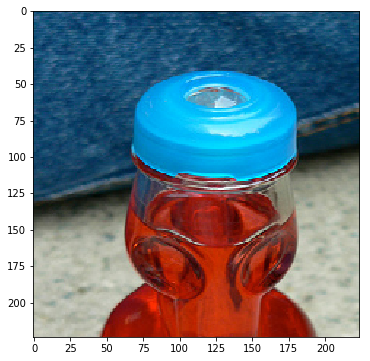

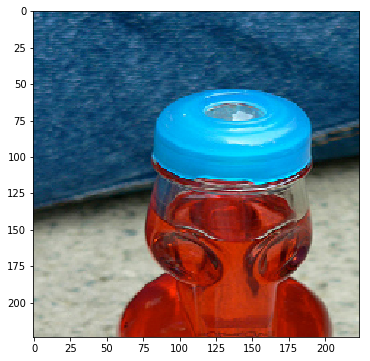

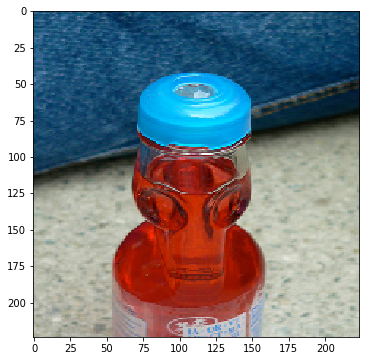

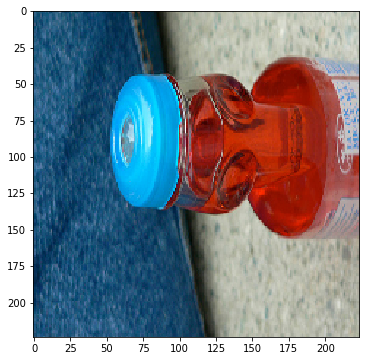

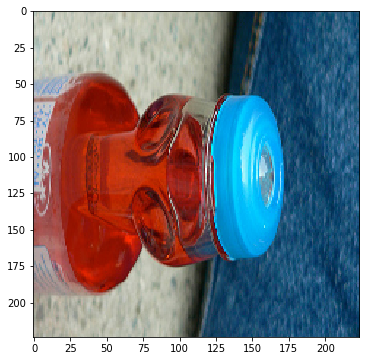

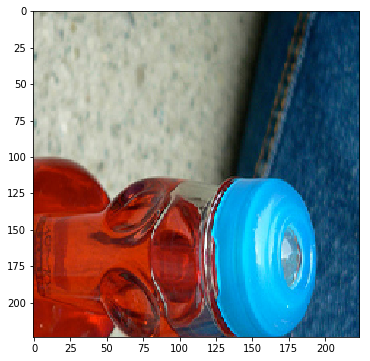

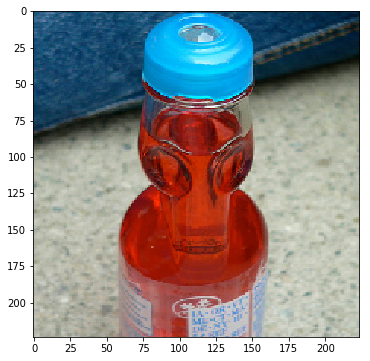

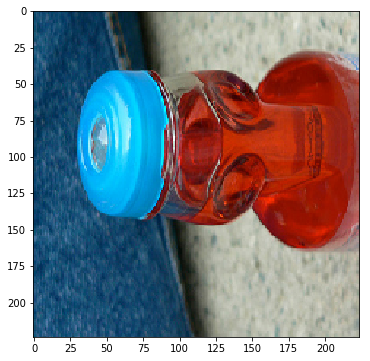

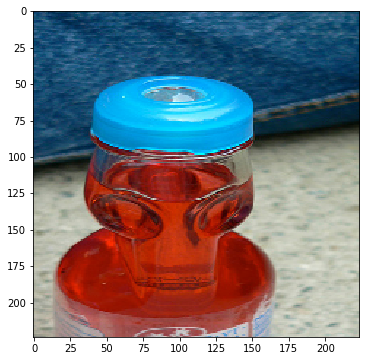

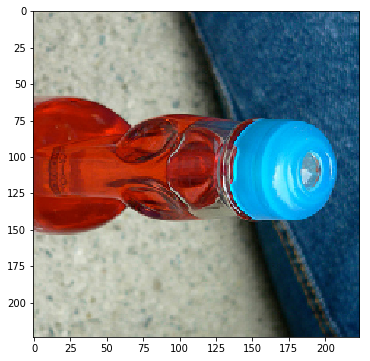

In [172]:
generate_batch_test1()

In [19]:
def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1)) 
            / predictions.shape[0])

In [20]:
num_steps = 20001
with tf.Session(graph=graph) as session:
    saver.restore(session,'./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter6000.ckpt')
    print('Model restored')
    for step in range(num_steps)[6000:]:
        batch_data,batch_labels = generate_batch()
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, train_loss, train_prediction], feed_dict=feed_dict)
        if (step % 100 == 0):
            print('Batch loss at step %d: %f' % (step, l))
            print('Batch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
        if (step % 1000 == 0):
            accuracy_full = 0.
            for i in range(N):
                test_data,test_labels = classes[i][4],classes[i][5]
                acc = accuracy(test_prediction.eval(feed_dict={tf_test_dataset:test_data}), test_labels)
                accuracy_full += acc
            accuracy_full = accuracy_full/N
            print('Test accuracy: %.1f%%' % accuracy_full)
            save_path = saver.save(session, "./modelTmp/clv0_2augmv0_2/model_v022_augm_v0_2_iter"+str(step)+".ckpt")
            print("Model saved in file: %s" % save_path)

INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter6000.ckpt
Model restored
Batch loss at step 6000: 1.454006
Batch accuracy: 54.0%
Test accuracy: 48.5%
Model saved in file: ./modelTmp/clv0_2augmv0_2/model_v022_augm_v0_2_iter6000.ckpt


C:\Users\Klapeyron\Anaconda3\envs\tf-gpu\lib\site-packages\PIL\TiffImagePlugin.py:725: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 0
  " Skipping tag %s" % (size, len(data), tag))


Batch loss at step 6100: 1.234781
Batch accuracy: 63.0%
Batch loss at step 6200: 1.260039
Batch accuracy: 57.0%
Batch loss at step 6300: 1.213967
Batch accuracy: 59.0%
Batch loss at step 6400: 1.407165
Batch accuracy: 55.0%
Batch loss at step 6500: 1.267263
Batch accuracy: 56.0%
Batch loss at step 6600: 1.128586
Batch accuracy: 57.0%
Batch loss at step 6700: 1.211660
Batch accuracy: 60.0%
Batch loss at step 6800: 1.033248
Batch accuracy: 67.0%
Batch loss at step 6900: 1.358590
Batch accuracy: 52.0%
Batch loss at step 7000: 1.368664
Batch accuracy: 49.0%
Test accuracy: 52.4%
Model saved in file: ./modelTmp/clv0_2augmv0_2/model_v022_augm_v0_2_iter7000.ckpt
Batch loss at step 7100: 1.304955
Batch accuracy: 55.0%
Batch loss at step 7200: 1.399035
Batch accuracy: 56.0%
Batch loss at step 7300: 1.122297
Batch accuracy: 64.0%
Batch loss at step 7400: 1.262334
Batch accuracy: 62.0%
Batch loss at step 7500: 1.150861
Batch accuracy: 54.0%
Batch loss at step 7600: 1.171815
Batch accuracy: 61.0%
B

Batch loss at step 18400: 0.862645
Batch accuracy: 69.0%
Batch loss at step 18500: 0.741971
Batch accuracy: 77.0%
Batch loss at step 18600: 0.820677
Batch accuracy: 76.0%
Batch loss at step 18700: 0.813695
Batch accuracy: 74.0%
Batch loss at step 18800: 0.908589
Batch accuracy: 69.0%
Batch loss at step 18900: 0.681571
Batch accuracy: 76.0%
Batch loss at step 19000: 1.142915
Batch accuracy: 60.0%
Test accuracy: 56.3%
Model saved in file: ./modelTmp/clv0_2augmv0_2/model_v022_augm_v0_2_iter19000.ckpt
Batch loss at step 19100: 0.818530
Batch accuracy: 70.0%
Batch loss at step 19200: 0.855282
Batch accuracy: 73.0%
Batch loss at step 19300: 0.778272
Batch accuracy: 76.0%
Batch loss at step 19400: 0.543056
Batch accuracy: 80.0%
Batch loss at step 19500: 0.683354
Batch accuracy: 74.0%
Batch loss at step 19600: 0.757844
Batch accuracy: 73.0%
Batch loss at step 19700: 0.776763
Batch accuracy: 75.0%
Batch loss at step 19800: 0.733950
Batch accuracy: 75.0%
Batch loss at step 19900: 0.879111
Batch 

## Results

In [48]:
test_acc_loss = []
all_without_train_acc_loss = []
train_acc_loss = []

In [49]:
with tf.Session(graph=graph) as session:
    saver.restore(session,'./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt')
    print('Model restored')
    batch_data,batch_labels = generate_batch()
    feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
    l, predictions = session.run([train_loss, train_prediction], feed_dict=feed_dict)
    print('Batch loss at step: %f' % (l))
    print('Batch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
    accuracy_full = 0.
    for i in range(N):
        test_data,test_labels = classes[i][4],classes[i][5]
        feed_dict={tf_test_dataset:test_data,tf_test_labels:test_labels}
        l, predictions = session.run([test_loss, test_prediction], feed_dict=feed_dict)
        acc = accuracy(predictions, test_labels)
        print(classes[i][0],acc,'%.1f'%l)
        test_acc_loss.append([classes[i][1],acc,l])
        accuracy_full += acc
    accuracy_full = accuracy_full/N
    print('Full test accuracy: %.1f%%' % accuracy_full)

INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
Model restored
Batch loss at step: 1.036222
Batch accuracy: 63.0%
bottle 50.0 1.3
headphones 62.0 1.1
human 58.0 1.4
key 53.0 1.6
laptop 49.0 1.6
pen 64.0 1.5
phone 46.0 1.6
shoes 56.0 1.6
sodacan 56.0 1.2
wallet 72.0 0.9
Full test accuracy: 56.6%


In [52]:
def accuracy_loss_for_class_without_train(class_number):
    with tf.Session(graph=graph) as session:
        saver.restore(session,'./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt')
        predictions = []
        labels = []
        losses = []
        label = np.zeros(N)
        label[class_number] = 1
        name = classes[class_number][0]
        for i in range(len(os.listdir('./data/data_training/'+name))):
            if (i not in classes[class_number][2]):
                img = imageio.imread('./data/data_training/'+name
                                     +'/imagenet'+name+str(i)
                                     +'.jpg').astype(np.float32)
                image_data = (img - pixel_depth / 2) / pixel_depth
                feed_dict={tf_one_image : [image_data],tf_one_label : [label]}
                prediction = session.run(one_prediction, feed_dict=feed_dict)
                predictions.append(prediction[0])
                labels.append(label)
                losses.append(-np.log(prediction[0][class_number]))
        predictions = np.array(predictions)
        labels = np.array(labels)
        losses = np.array(losses)
        acc = accuracy(predictions,labels)
        l = losses.mean()
    return acc,l

In [53]:
for i in range(10):
    acc,l = accuracy_loss_for_class_without_train(i)
    print(classes[i][0],acc,l)
    all_without_train_acc_loss.append([classes[i][1],acc,l])

INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
bottle 36.0443622921 2.10551
INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
headphones 70.8333333333 0.845366
INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
human 61.9605753863 1.13915
INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
key 53.3101045296 1.53595
INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
laptop 44.7415329768 1.69422
INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
pen 34.5412039743 2.68789
INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
phone 48.786407767 1.6069
INFO:tensorflow:Restoring parameters fr

In [56]:
def accuracy_loss_for_class_train(class_number):
    with tf.Session(graph=graph) as session:
        saver.restore(session,'./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt')
        predictions = []
        labels = []
        losses = []
        label = np.zeros(N)
        label[class_number] = 1
        name = classes[class_number][0]
        for i in range(classes[class_number][2].shape[0]):
            img = imageio.imread('./data/data_training/'+name
                                    +'/imagenet'+name+str(classes[class_number][2][i])
                                    +'.jpg').astype(np.float32)
            image_data = (img - pixel_depth / 2) / pixel_depth
            feed_dict={tf_one_image : [image_data],tf_one_label : [label]}
            prediction = session.run(one_prediction, feed_dict=feed_dict)
            predictions.append(prediction[0])
            labels.append(label)
            losses.append(-np.log(prediction[0][class_number]))
        predictions = np.array(predictions)
        labels = np.array(labels)
        losses = np.array(losses)
        acc = accuracy(predictions,labels)
        l = losses.mean()
    return acc,l

In [57]:
for i in range(10):
    acc,l = accuracy_loss_for_class_train(i)
    print(classes[i][0],acc,l)
    train_acc_loss.append([classes[i][1],acc,l])

INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
bottle 98.9214175655 0.113531
INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
headphones 99.8459167951 0.0666092
INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
human 99.6918335901 0.103602
INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
key 99.5377503852 0.0838306
INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
laptop 99.8459167951 0.0843588
INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
pen 99.5377503852 0.0954711
INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/6000/model_v022_augm_v0_2_iter17000.ckpt
phone 99.8459167951 0.057843
INFO:tensorflow:Restoring p

In [58]:
train_acc_loss

[[1731, 98.921417565485356, 0.11353146],
 [865, 99.845916795069343, 0.066609152],
 [2526, 99.691833590138671, 0.1036015],
 [936, 99.537750385208014, 0.083830625],
 [1771, 99.845916795069343, 0.084358752],
 [2360, 99.537750385208014, 0.095471084],
 [1473, 99.845916795069343, 0.057843015],
 [9337, 99.383667180277357, 0.066450119],
 [998, 99.383667180277357, 0.087298803],
 [749, 99.845916795069343, 0.069571391]]

In [59]:
test_acc_loss = np.array(test_acc_loss)
all_without_train_acc_loss = np.array(all_without_train_acc_loss)

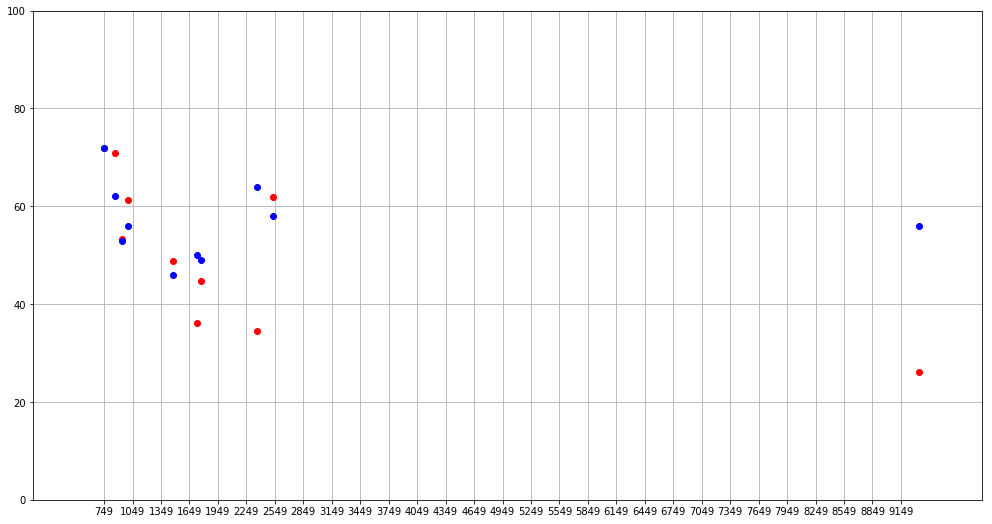

In [61]:
plt.figure(1, figsize=(17, 9))
plt.axis([0,10000,0,100])
plt.xticks(np.arange(min(all_without_train_acc_loss[:,0]), max(all_without_train_acc_loss[:,0])+1, 300.0))
plt.grid(True)
plt.plot(all_without_train_acc_loss[:,0],all_without_train_acc_loss[:,1],'ro')
plt.plot(test_acc_loss[:,0],test_acc_loss[:,1],'ro',color='blue')

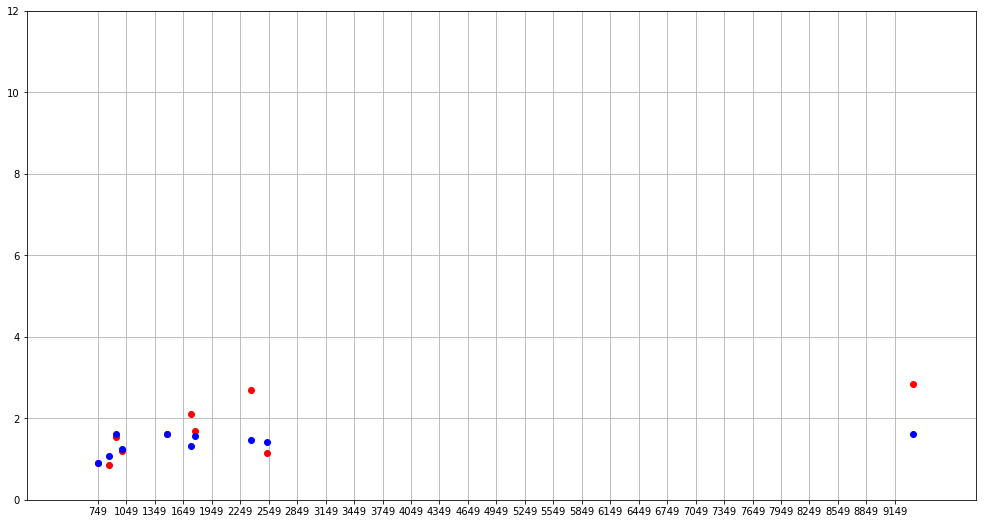

In [62]:
plt.figure(1, figsize=(17, 9))
plt.axis([0,10000,0,12])
plt.xticks(np.arange(min(all_without_train_acc_loss[:,0]), max(all_without_train_acc_loss[:,0])+1, 300.0))
plt.grid(True)
plt.plot(all_without_train_acc_loss[:,0],all_without_train_acc_loss[:,2],'ro')
plt.plot(test_acc_loss[:,0],test_acc_loss[:,2],'ro',color='blue')

In [63]:
for i in range(10):
    print(classes[i][0],classes[i][1])

bottle 1731
headphones 865
human 2526
key 936
laptop 1771
pen 2360
phone 1473
shoes 9337
sodacan 998
wallet 749


# Results Last

In [9]:
def results(conf_file,net_name):
    results_acc = [[],[],[],[],[],[]]
    results_loss = [[],[],[],[],[],[]]
    
    test_acc_loss = []
    all_without_train_acc_loss = []
    train_acc_loss = []
    
    def accuracy_loss_for_class_train(class_number):
        predictions = []
        labels = []
        losses = []
        label = np.zeros(N)
        label[class_number] = 1
        name = classes[class_number][0]
        for i in range(classes[class_number][2].shape[0]):
            img = imageio.imread('./data/data_training/'+name
                                    +'/imagenet'+name+str(classes[class_number][2][i])
                                    +'.jpg').astype(np.float32)
            image_data = (img - pixel_depth / 2) / pixel_depth
            feed_dict={tf_one_image : [image_data],tf_one_label : [label]}
            prediction = session.run(one_prediction, feed_dict=feed_dict)
            predictions.append(prediction[0])
            labels.append(label)
            losses.append(-np.log(prediction[0][class_number]))
        predictions = np.array(predictions)
        labels = np.array(labels)
        losses = np.array(losses)
        acc = accuracy(predictions,labels)
        l = losses.mean()
        return acc,l

    def accuracy_loss_for_class_without_train(class_number):
        predictions = []
        labels = []
        losses = []
        label = np.zeros(N)
        label[class_number] = 1
        name = classes[class_number][0]
        for i in range(len(os.listdir('./data/data_training/'+name))):
            if (i not in classes[class_number][2]):
                img = imageio.imread('./data/data_training/'+name
                                     +'/imagenet'+name+str(i)
                                     +'.jpg').astype(np.float32)
                image_data = (img - pixel_depth / 2) / pixel_depth
                feed_dict={tf_one_image : [image_data],tf_one_label : [label]}
                prediction = session.run(one_prediction, feed_dict=feed_dict)
                predictions.append(prediction[0])
                labels.append(label)
                losses.append(-np.log(prediction[0][class_number]))
        predictions = np.array(predictions)
        labels = np.array(labels)
        losses = np.array(losses)
        acc = accuracy(predictions,labels)
        l = losses.mean()
        return acc,l
    
    with tf.Session(graph=graph) as session:
        saver.restore(session,conf_file)
        
        for i in range(N):
            acc,l = accuracy_loss_for_class_train(i)
            train_acc_loss.append([classes[i][1],acc,l])
        train_acc_loss = np.array(train_acc_loss)
        
        for i in range(N):
            test_data,test_labels = classes[i][4],classes[i][5]
            feed_dict={tf_test_dataset:test_data,tf_test_labels:test_labels}
            l, predictions = session.run([test_loss, test_prediction], feed_dict=feed_dict)
            acc = accuracy(predictions, test_labels)
            test_acc_loss.append([classes[i][1],acc,l])
        test_acc_loss = np.array(test_acc_loss)
        test_acc_loss_mean = (test_acc_loss[:,1].mean(),test_acc_loss[:,2].mean())
        print('test_acc_loss_mean',test_acc_loss_mean)
    
        for i in range(N):
            acc,l = accuracy_loss_for_class_without_train(i)
            all_without_train_acc_loss.append([classes[i][1],acc,l])
        all_without_train_acc_loss = np.array(all_without_train_acc_loss)
    
    def s(st):
        return st[1]
    classessorted = []
    for i in range(N):
        classessorted.append([i,classes[i][1]])
    classessorted.sort(key=s)
    classessorted = np.array(classessorted)
    
    for i in range(N):
        j = classessorted[i][0]
        results_acc[0].append(j)
        results_acc[1].append(train_acc_loss[j][0])
        results_acc[2].append(train_acc_loss[j][1])
        results_acc[3].append(test_acc_loss[j][1])
        results_acc[4].append(all_without_train_acc_loss[j][1])
        results_acc[5].append(np.abs(all_without_train_acc_loss[j][1]-test_acc_loss[j][1]))
        
        results_loss[0].append(j)
        results_loss[1].append(train_acc_loss[j][0])
        results_loss[2].append(train_acc_loss[j][2])
        results_loss[3].append(test_acc_loss[j][2])
        results_loss[4].append(all_without_train_acc_loss[j][2])
        results_loss[5].append(np.abs(all_without_train_acc_loss[j][2]-test_acc_loss[j][2]))
    
    results_acc = np.round(results_acc,1)
    results_loss = np.round(results_loss,1)
    
    results_acc = np.array(results_acc)
    results_loss = np.array(results_loss)
    
    d = pd.DataFrame({
        'index':np.array(results_acc[0],dtype=np.int32),
        'images':np.array(results_acc[1],dtype=np.int32),
        'train':results_acc[2],
        'test':results_acc[3],
        'all':results_acc[4],
        'all-test':results_acc[5]
    })
    d.to_csv('./Clapeyron_CNN_research/tableAcc'+net_name+'.csv',index=False,
             columns=['index','images','train','test','all','all-test'])
    
    d = pd.DataFrame({
        'index':np.array(results_loss[0],dtype=np.int32),
        'images':np.array(results_loss[1],dtype=np.int32),
        'train':results_loss[2],
        'test':results_loss[3],
        'all':results_loss[4],
        'all-test':results_loss[5]
    })
    d.to_csv('./Clapeyron_CNN_research/tableLoss'+net_name+'.csv',index=False,
                columns=['index','images','train','test','all','all-test'])

In [16]:
results('./modelTmp/clv0_2augmv0_2/saved/model_v022_augm_v0_2_iter17000.ckpt','Clapeyron_CNN_v0.2_augm_v0.1')

INFO:tensorflow:Restoring parameters from ./modelTmp/clv0_2augmv0_2/saved/model_v022_augm_v0_2_iter17000.ckpt
test_acc_loss_mean (56.600000000000001, 1.3812794446945191)
